January 30, 2021

Contributors
- Sergei V. Kalinin - concept, GAN, workflow integration and analysis
- Mani Valleti - original Ising code, analysis functions
- Rama Vasudevan - Ising code adaptation to full functions
- Maxim Ziatdinov - VAE and rVAE: 
- Atienza book: DCGAN and WGAN 

Funding:
- SVK and MV: STEM FWP
- MZ: CNMS




# Ising model

In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm

import math
import os

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

<ipython-input-1-358934092b0a>:11: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from mpl_toolkits.axes_grid1.colorbar import colorbar


In [2]:
#@title Ising Model
class IsingSim():
  
  """This class performs Ising model simulations on a 2D grid. Interaction parameters are given by a matrix at each lattice site. 
  Field dependence is not supported at this time but will be in due course. The simulator outputs configurations after equlibrium
  as well as the trajectories, if specifically requested.
  Inputs:
    - N : (integer) - Size of lattice will be N^2. Only 2D square lattice is supported at this stage.
    - J_mat: (numpy matrix of shape(5,5)) - entries being floats for interaction parameters. Self-interaction (middle element of matrix)=0. 
              or: (list) of size(5,5) with each element belonging to scipy distribution from which to draw J value (for bond disorder)
    - T: (float) - Reduced temperature for simulation
    - save_trajectories: (Boolean) - whether to save trajectories, or only final state. Default False.
    - eqSteps: (integer) number of Monte-Carlo steps for equlibration before simulation starts. Default 750. AKA 'burn-in'.
    - mcSteps: (integer) number of Monte-Carlo for simulation. Default 750.
  Outputs: Several outputs are available, including trajectories (if called), configurations (i.e., the 2D states) and configurations histograms.
  These can be obtained by calling methods self.configurations(), self.histograms() and self.trajectories()"""

  def __init__(self, N = 40, J_mat = None, T = 2.7, save_trajectories = False,
               eqSteps = 750, mcSteps = 750):
    self.N = N
    
    #If no J matrix is provided we default to isotropic J interaction with NN with value 0.5
    if J_mat == None:
      J_mat = np.zeros((5,5))
      J_mat[1,2] = J_mat[2,1] = J_mat[2,3] = J_mat[3,2] = 0.5 #Defaulting to 0.5 for NN, all others zeroed out.
    
    self.J_mat = J_mat

    try:
      rv = J_mat[1,2]
    except TypeError:
      rv = J_mat[1][2] #in case we have a list
      
    if 'dist' in str(type(rv)): #in this case we have random bond disorder situation
      self.bond_disorder = True
      self.J_lattice = self.make_J_lattice()
      self.J_mat = None
    else:
      self.bond_disorder = False
      self.J_lattice = None

    self.save_trajectories = save_trajectories
    self.eqSteps = eqSteps
    self.mcSteps = mcSteps
    self.config = self.initialState(random = False)
    self.T = T
    self.configs_list = self.make_configs_list()

  def initialState(self, random = False):   
    ''' Generates a lattice with spin configurations drawn randomly [-1 or 1] if random=True
    Else, the lattice is generated with all sites = 1 '''

    if random==True: state = 2*np.random.randint(2, size=(self.N,self.N))-1
    else: state = np.ones([self.N,self.N])

    return state

  def make_J_lattice(self):   

    ''' Return a matrix size (N,N,5,5) signifying interaction parameters at each lattice site, drawn from 
    distributions provided '''

    J_lattice = np.zeros(shape=(self.N, self.N, 5,5))
    for i in range(self.N):
      for j in range(self.N):
        for k in range(5):
          for l in range(5):
            if 'dist' in str(type(self.J_mat[k][l])):
              J_lattice[i,j,k,l] = self.J_mat[k][l].rvs(1)
            else: J_lattice[i,j,k,l] = self.J_mat[k][l]
    
    return J_lattice

  def mcmove(self, config):
    '''Monte Carlo move using Metropolis algorithm '''
    
    M = 5 #neighborhood size (M^2). Do not change!
    beta = 1.0/self.T

    for i in range(self.N):
      for j in range(self.N):
        if self.bond_disorder: J_mat = self.J_lattice[i,j,:,:]
        else: J_mat = self.J_mat

        cost = 0.0
        s =  np.copy(config[i, j])

        for p in range(-int(M/2), int(M/2)+1, 1):
          for q in range(-int(M/2), int(M/2)+1, 1):
            cost += 2 * J_mat[int(M/2)+p, int(M/2)+q] * config[(i+p)%self.N,(j+q)%self.N] * config[i,j]
        
        if cost < 0:
          s *= -1
        elif rand() < np.exp(-cost*beta):
          s *= -1
        config[i, j] = s
    return config


  def calcEnergy(self, config):
    '''Returns the energy of the current configuration'''
    M = 5
    energy = 0.0
    for i in range(len(config)):
      for j in range(len(config)):
        #In case we have bond disorder
        if self.bond_disorder: J_mat = self.J_lattice[i,j,:,:]
        else: J_mat = self.J_mat #otherwise, no

        s = config[i,j]
        for p in range(-int(M/2), int(M/2)+1, 1):
          for q in range(-int(M/2), int(M/2)+1, 1):
            energy += -J_mat[int(M/2)+p, int(M/2)+q] * config[(i+p)%self.N,(j+q)%self.N] * config[i,j]

    return energy/4.0


  def calcMag(self, config):
    '''Magnetization of a given configuration'''
    return float(np.sum(config))

  def calcAbsMag(self, config):
    ''' Absolute Magnetization of a given configuration'''
    return float(np.abs(np.sum(config)))
  
  def performIsingSim(self):
    
    E1, M1, E2, M2 = 0.0,0.0,0.0,0.0    #These are all the average properties of all MC steps used
        
    config = np.copy(self.config)
    T = self.T
    if self.save_trajectories: config_mat = np.zeros([self.mcSteps,self.N,self.N])   #Saving all the configurations
    

    print('\n---Performing Equlibration---\n')
    for i in tqdm(range(self.eqSteps)):
        config = self.mcmove(config)

    print('\n---Finished...\n----Performing MC Moves----\n')
    for j in tqdm(range(self.mcSteps)):
        config = self.mcmove(config)
        Ene = self.calcEnergy(config)
        Mag = self.calcAbsMag(config)

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag * Mag
        E2 = E2 + Ene * Ene
        
        if self.save_trajectories: config_mat[j] = config
    
    print('Completed. Saving')    
    Energy = E1 / (self.mcSteps * self.N * self.N)
    Magnetization = M1 / (self.mcSteps * self.N * self.N)
    n1, n2  = 1.0/(self.mcSteps*self.N*self.N), 1.0/(self.mcSteps*self.mcSteps*self.N*self.N) 
    iT = 1.0/self.T
    iT2 = iT*iT
    SpecificHeat = (n1*E2 - n2*E1*E1)*iT2
    Susceptibility = (n1*M2 - n2*M1*M1)*iT
    # SpecificHeat = (E2 / self.mcSteps - E1 * E1 / (self.mcSteps * self.mcSteps)) / (self.N * self.T * self.T)
    # Susceptibility = (M2 / self.mcSteps - M1 * M1 / (self.mcSteps * self.mcSteps)) / (self.N * self.T)

    self.config = config
    config_hist, config_hist_norm = self.get_config_histogram()

    if self.save_trajectories:
      results_dict = {'config': config_mat, 'Energy': Energy, 'Magnetization': Magnetization,
      'SpecificHeat': SpecificHeat, 'Susceptibility': Susceptibility, 
      'Histogram': config_hist_norm}
    else:
      results_dict = {'Energy': Energy, 'Magnetization': Magnetization,
      'SpecificHeat': SpecificHeat, 'Susceptibility': Susceptibility,
      'Histogram': config_hist_norm}
    
    self.results = results_dict

    return 'Completed simulation'
    
  def make_configs_list(self):

    #Let's write down possible configurations for nearest neighbors
    all_configs = [
               #Configurations
               
               #all -1
               [-1,-1,-1,-1,-1],               #1

               #one 1
               [-1,-1,-1,-1,1],               #2
               [-1,-1,-1,1,-1],               #3
               [-1,-1,1,-1,-1],               #4
               [-1,1,-1,-1,-1],               #5
               [1,-1,-1,-1,-1],               #6
    
               #two 1s
               [1,1,-1,-1,-1],               #7
               [1,-1,1,-1,-1],               #8
               [1,-1,-1,1,-1],               #9
               [1,-1,-1,-1,1],               #10
               [-1,1,1,-1,-1],               #11
               [-1,1,-1,1,-1],               #12
               [-1,1,-1,-1,1],               #13
               [-1,-1,1,1,-1],               #14
               [-1,-1,1,-1,1],               #15
               [-1,-1,-1,1,1],               #16
               
               #three ones
               [1,1,1,-1,-1],               #17
               [1,1,-1,1,-1],               #18
               [1,1,-1,-1,1],               #19
               [1,-1,1,1,-1],               #20
               [1,-1,1,-1,1],               #21
               [1,-1,-1,1,1],               #22
               [-1,1,1,1,-1],               #23
               [-1,1,-1,1,1],               #24
               [-1,-1,1,1,1],               #25
               [-1,1,1,-1,1],               #26

               #four 1s
               [1,-1,1,1,1],               #27
               [1,1,-1,1,1],               #28
               [1,1,1,-1,1],               #29
               [1,1,1,1,-1],               #30
               [-1,1,1,1,1],               #31

               #five 1s
               [1,1,1,1,1],               #32
      ]

    return all_configs

  def get_config_histogram(self):

    config_hist = np.zeros(shape=(len(self.configs_list)))

    for i in range(self.N):
        for j in range(self.N):
            cen = self.config[i,j]
            a = self.config[(i+1)%self.N,j]
            b = self.config[i,(j+1)%self.N]
            c = self.config[(i-1)%self.N,j]
            d = self.config[i,(j-1)%self.N]
            
            config_vec = [cen, a, b, c, d]
            #Now let's get the configuration number
            config_number = self.configs_list.index(config_vec)
            config_hist[int(config_number)]=config_hist[int(config_number)]+1

    #normalize it to get probabilities
    config_hist_norm = config_hist / (self.N * self.N)

    return config_hist, config_hist_norm
    


In [3]:
#@title Similarity Function (list)
#Function that defines how close we are to selected microstructures

#Remember that tile will be repeated.  
#Consider dividing by magnetization for specific structures (if plus minis does not matter). Now will be done when plotted
#Normalized by N^2

from scipy import signal
from scipy import misc

def similarity_function_list(config):
  N_Ising = config.shape[1]
  T_Ising = config.shape[0]

  #this is the tile that we look for
  tile_seg_dictionary = {
      'FM': [[1., 1., 1.,1], [1.,1.,1.,1],[1., 1., 1.,1],[1.,1.,1.,1]],
      'AFM': [[1., -1., 1.,-1], [-1.,1.,-1.,1],[1., -1., 1.,-1],[-1.,1.,-1.,1]],
      'D-AFM': [[1., 1., -1.,-1], [1.,1.,-1.,-1],[-1., -1., 1.,1],[-1.,-1.,1.,1]],
      'stripe': [[1., 1., 1.,1], [-1.,-1.,-1.,-1],[1., 1., 1.,1],[-1.,-1.,-1.,-1]], 
      'double stripe': [[1., 1., 1.,1], [1.,1.,1.,1],[-1., -1., -1.,-1],[-1.,-1.,-1.,-1]],
      '3:1': [[1., 1., 1.,1], [1.,1.,1.,1],[1., 1., 1.,1],[-1.,-1.,-1.,-1]],
      '2:1': [[1., 1.,- 1.,-1], [-1.,-1.,1.,1],[1., 1., -1.,-1],[-1.,-1.,1.,1]],
      '3:1_45': [[-1., 1., 1.,1], [1.,-1.,1.,1],[1., 1., -1.,1],[1.,1.,1.,-1]],
  }

  similarity_dictionary = {}
  #extended_tile_dictionary = {}

  for key, value in tile_seg_dictionary.items():
    tile_seg = tile_seg_dictionary[key]
    rep = int(N_Ising/len(tile_seg))
    extended_tile = np.tile(tile_seg, [rep, rep]) 

    #extended_tile_dictionary.update({key: extended_tile})


    similarity_array = np.zeros(T_Ising)
    similarity_array_T = np.zeros(T_Ising)
    for z in range(T_Ising):
      similarity_array[z]  = np.amax(signal.correlate2d(config[z, :,:], extended_tile, boundary='wrap', mode='same'))
      similarity_array_T[z] = np.amax(signal.correlate2d(config[z, :,:].T, extended_tile, boundary='wrap', mode='same'))
      
        
    similarity = (np.maximum(np.mean(similarity_array),np.mean(similarity_array_T)))/(N_Ising*N_Ising)
    similarity_dictionary.update({key: similarity})

  return similarity_dictionary

In [4]:
 #define the model. You should supply a J_mat, like
from scipy.stats import norm

#Create interactions matrix

J_mat = [[0,0,0,0,0],
         [0,0,norm(loc=-1.0, scale = 0.01),0,0],
         [0,norm(loc=-1.0, scale = 0.01),0,norm(loc=-1.0, scale = 0.01),0],
         [0,0,norm(loc=-1.0, scale = 0.01),0,0],
         [0,0,0,0,0]
         ]

#Instantiate Model
ising_model =  IsingSim(N=20, J_mat = J_mat, save_trajectories=True, T = 2.4, eqSteps = 100, mcSteps = 100)

In [5]:
ising_model.performIsingSim()

  7%|▋         | 7/100 [00:00<00:01, 67.32it/s]


---Performing Equlibration---



  5%|▌         | 5/100 [00:00<00:02, 40.71it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 100/100 [00:02<00:00, 39.37it/s]

Completed. Saving


'Completed simulation'

config
Energy
Magnetization
SpecificHeat
Susceptibility
Histogram

Energy: -0.672944
 Susceptibility: 0.031658 
 Magnetization 0.018050 
 Specific Heat: 0.314806



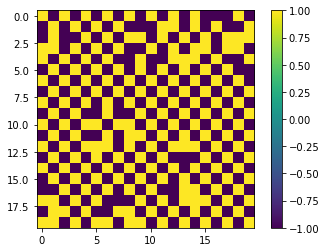

In [6]:
results = ising_model.results
for key in results: print(key)
print("\nEnergy: {0:2f}\n Susceptibility: {1:2f} \n Magnetization {2:2f} \n Specific Heat: {3:2f}\n".format(
    results['Energy'], 
      results['Susceptibility'], 
      results['Magnetization'], 
      results['SpecificHeat']))

config = results['config']
histogram = results['Histogram']

plt.figure()
plt.imshow(config[90,:,:])
plt.colorbar()

In [7]:
#Define the function that takes Jc and Js and returns parameter of interest

def J2_to_S_func(Jci, Jsi):

  Jc = Jci
  Js = Jsi

  J_mat = [[0,0,0,0,0],
            [0,norm(loc=Js, scale = 0.01),norm(loc=Jc, scale = 0.01),norm(loc=Js, scale = 0.01),0],
           [0,norm(loc=Jc, scale = 0.01),0,norm(loc=Jc, scale = 0.01),0],
            [0,norm(loc=Js, scale = 0.01),norm(loc=Jc, scale = 0.01),norm(loc=Js, scale = 0.01),0],
            [0,0,0,0,0]]

  ising_model =  IsingSim(N=20, J_mat = J_mat, save_trajectories=True, T = 1, eqSteps = 200, mcSteps = 200)
  ising_model.performIsingSim()
  
  #st = similarity_function_list(ising_model.results['config'])
  #st = ising_model.results['SpecificHeat']

  config = ising_model.results['config']

  return config  # st['FM']

In [8]:
# Note that Ising function operates on indices
# The range of J's is defined within the function

ising_data = J2_to_S_func(-0.4, 0)

  4%|▎         | 7/200 [00:00<00:02, 68.57it/s]


---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:04, 39.24it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:04<00:00, 40.71it/s]

Completed. Saving


(200, 20, 20)


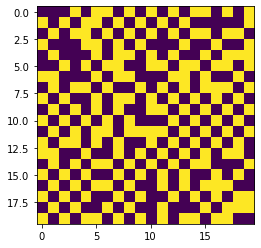

In [9]:
print(ising_data.shape)
plt.imshow(ising_data[2,:,:])

Snapshots of Ising model


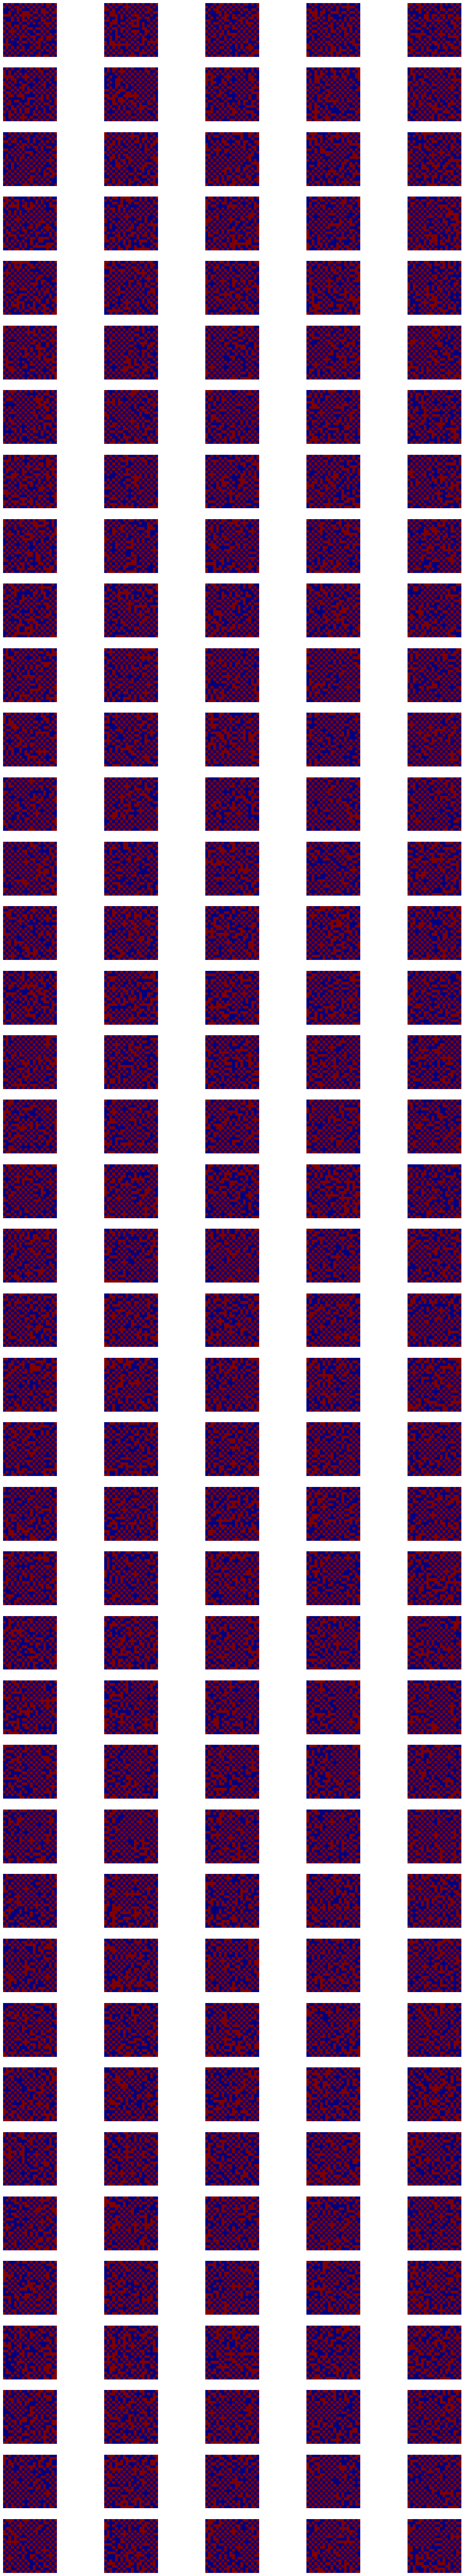

In [10]:
nc = ising_data.shape[0]

rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

print('Snapshots of Ising model')
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))   
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(ising_data[i,:,:], cmap = 'jet')
    ax2.axis('Off')
    # ax2.set_title('Time ' + str(i + 1))
plt.show()


**SVK Comment:** This part seems to be working. We define the fucntion that calculates propert of interest via numerical simulation of Ising model. By design, can make any parameter space (up to 24) and output thermodynamic parameters or similarity functions.

# Training set - constant J

- Need to run Ising model N times for a single set of parameters
- Concatenate the ground states taken M times per run
- Shuffle the resultant data set. This will form the training set for GAN for a single set of parameters J1, J2

Comment: 
- x_train should be like (60000, 28, 28, 1)

In [11]:
# Need ot define Ising field size as parameter
# And number of saves per run as a parameter

ising_temp = []
m_iter = 30

for j in range(m_iter):
  print(j)
  ising_data = J2_to_S_func(-0.6, 0)
  ising_temp.append(ising_data)

ising_temp = np.array(ising_temp).reshape(200*m_iter, 20, 20)
x_train = np.expand_dims(ising_temp, 3)  

  4%|▍         | 8/200 [00:00<00:02, 72.68it/s]

0

---Performing Equlibration---



  2%|▎         | 5/200 [00:00<00:04, 40.48it/s]


---Finished...
----Performing MC Moves----



  4%|▎         | 7/200 [00:00<00:02, 69.94it/s]

Completed. Saving
1

---Performing Equlibration---



  2%|▎         | 5/200 [00:00<00:04, 40.98it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
2

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:05, 37.51it/s]


---Finished...
----Performing MC Moves----



  4%|▎         | 7/200 [00:00<00:02, 68.10it/s]

Completed. Saving
3

---Performing Equlibration---



  2%|▎         | 5/200 [00:00<00:04, 41.29it/s]


---Finished...
----Performing MC Moves----



  4%|▍         | 8/200 [00:00<00:02, 72.30it/s]

Completed. Saving
4

---Performing Equlibration---



  2%|▎         | 5/200 [00:00<00:04, 40.46it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
5

---Performing Equlibration---



  2%|▎         | 5/200 [00:00<00:04, 40.88it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
6

---Performing Equlibration---



  2%|▎         | 5/200 [00:00<00:04, 41.08it/s]


---Finished...
----Performing MC Moves----



  4%|▍         | 8/200 [00:00<00:02, 71.30it/s]

Completed. Saving
7

---Performing Equlibration---



  2%|▎         | 5/200 [00:00<00:04, 41.96it/s]


---Finished...
----Performing MC Moves----



  4%|▍         | 8/200 [00:00<00:02, 73.29it/s]

Completed. Saving
8

---Performing Equlibration---



  2%|▎         | 5/200 [00:00<00:04, 41.61it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
9

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:05, 38.88it/s]


---Finished...
----Performing MC Moves----



  4%|▍         | 8/200 [00:00<00:02, 72.17it/s]

Completed. Saving
10

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:04, 39.60it/s]


---Finished...
----Performing MC Moves----



  4%|▍         | 8/200 [00:00<00:02, 73.06it/s]

Completed. Saving
11

---Performing Equlibration---



  2%|▎         | 5/200 [00:00<00:04, 40.94it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
12

---Performing Equlibration---



  2%|▎         | 5/200 [00:00<00:04, 42.38it/s]


---Finished...
----Performing MC Moves----



  4%|▍         | 8/200 [00:00<00:02, 71.45it/s]

Completed. Saving
13

---Performing Equlibration---



  2%|▎         | 5/200 [00:00<00:04, 41.48it/s]


---Finished...
----Performing MC Moves----



  4%|▎         | 7/200 [00:00<00:03, 64.08it/s]

Completed. Saving
14

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:05, 38.20it/s]


---Finished...
----Performing MC Moves----



  4%|▎         | 7/200 [00:00<00:02, 67.82it/s]

Completed. Saving
15

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:05, 39.01it/s]


---Finished...
----Performing MC Moves----



  4%|▍         | 8/200 [00:00<00:02, 72.01it/s]

Completed. Saving
16

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:05, 39.16it/s]


---Finished...
----Performing MC Moves----



  4%|▍         | 8/200 [00:00<00:02, 71.87it/s]

Completed. Saving
17

---Performing Equlibration---



  2%|▎         | 5/200 [00:00<00:04, 43.13it/s]


---Finished...
----Performing MC Moves----



  4%|▎         | 7/200 [00:00<00:02, 68.58it/s]

Completed. Saving
18

---Performing Equlibration---



  2%|▎         | 5/200 [00:00<00:04, 41.72it/s]


---Finished...
----Performing MC Moves----



  4%|▎         | 7/200 [00:00<00:02, 68.19it/s]

Completed. Saving
19

---Performing Equlibration---



  2%|▎         | 5/200 [00:00<00:04, 42.46it/s]


---Finished...
----Performing MC Moves----



  4%|▍         | 8/200 [00:00<00:02, 72.01it/s]

Completed. Saving
20

---Performing Equlibration---



  2%|▎         | 5/200 [00:00<00:04, 42.47it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
21

---Performing Equlibration---



  2%|▎         | 5/200 [00:00<00:04, 42.05it/s]


---Finished...
----Performing MC Moves----



  4%|▍         | 8/200 [00:00<00:02, 72.14it/s]

Completed. Saving
22

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:04, 39.34it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
23

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:05, 38.87it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 58.50it/s]

Completed. Saving
24

---Performing Equlibration---



  2%|▎         | 5/200 [00:00<00:04, 42.01it/s]


---Finished...
----Performing MC Moves----



  4%|▍         | 8/200 [00:00<00:02, 71.64it/s]

Completed. Saving
25

---Performing Equlibration---



  2%|▎         | 5/200 [00:00<00:04, 42.55it/s]


---Finished...
----Performing MC Moves----



  4%|▍         | 8/200 [00:00<00:02, 71.53it/s]

Completed. Saving
26

---Performing Equlibration---



  2%|▎         | 5/200 [00:00<00:04, 40.78it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
27

---Performing Equlibration---



  2%|▎         | 5/200 [00:00<00:04, 40.20it/s]


---Finished...
----Performing MC Moves----



  4%|▍         | 8/200 [00:00<00:02, 72.22it/s]

Completed. Saving
28

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:05, 37.83it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
29

---Performing Equlibration---



  2%|▎         | 5/200 [00:00<00:04, 40.79it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:04<00:00, 40.16it/s]

Completed. Saving


In [12]:
# Need to add save function
# And calculate as a function of J

In [13]:
#from google.colab import drive
#drive.mount('/content/drive')

In [14]:
#np.save('test3.npy', a)   
#d = np.load('test3.npy')

In [15]:
print(np.array(ising_temp).shape)
x_train.shape

(6000, 20, 20)


(6000, 20, 20, 1)

In [16]:
x_train_gan = (x_train+1)/2
print(x_train_gan.min(), x_train_gan.max())

0.0 1.0


In [17]:
'''
print(x_train_gan.shape)

for i, im in enumerate(x_train_gan):
  x_train_gan[i,:,:,0] = im[:,:,0] + np.random.normal(loc=0.0, scale=0.1, size=(20,20))
'''

'\nprint(x_train_gan.shape)\n\nfor i, im in enumerate(x_train_gan):\n  x_train_gan[i,:,:,0] = im[:,:,0] + np.random.normal(loc=0.0, scale=0.1, size=(20,20))\n'

Snapshots of Ising model


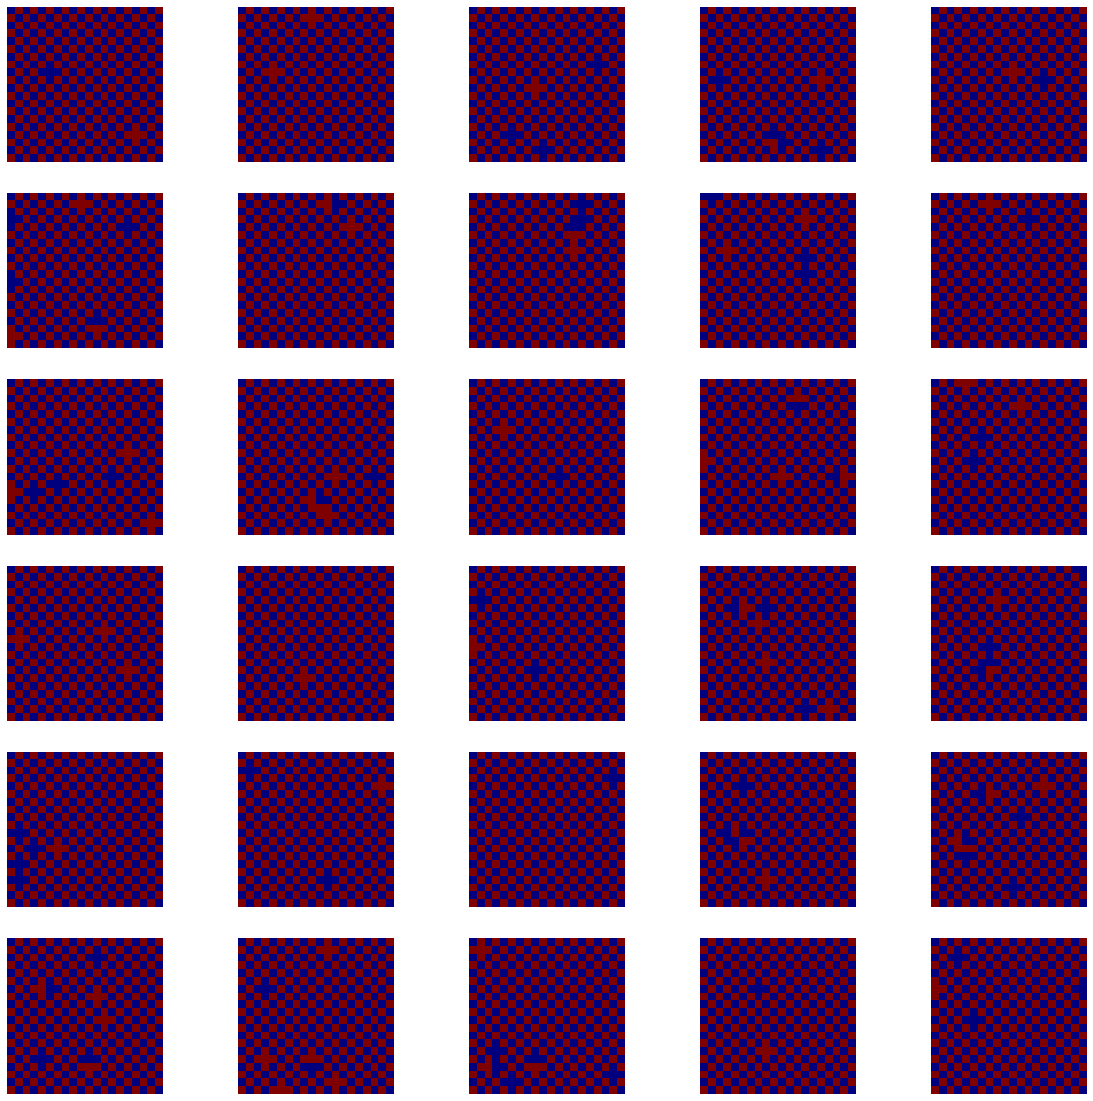

In [18]:
nc = 30 #x_train_gan.shape[0]

rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

print('Snapshots of Ising model')
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))   
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(x_train_gan[i,:,:,0], cmap = 'jet')
    ax2.axis('Off')
    # ax2.set_title('Time ' + str(i + 1))
plt.show()

In [19]:
print(x_train_gan.min(), x_train_gan.max())

0.0 1.0


# Training set - variable J

In [ ]:
# Need ot define Ising field size as parameter
# And number of saves per run as a parameter

ising_temp = []
ising_J = []
m_iter = 160

for j in range(m_iter):
  Jt = -1 + j/80
  print(j, Jt) 
  
  for k in range(200):
    ising_J.append(Jt)

  ising_data = J2_to_S_func(Jt, 0)
  ising_temp.append(ising_data)

ising_temp = np.array(ising_temp).reshape(200*m_iter, 20, 20)
ising_J = np.array(ising_J)

0 -1.0


  3%|▎         | 6/200 [00:00<00:03, 54.83it/s]


---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 30.69it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 54.03it/s]

Completed. Saving
1 -0.9875

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.62it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 52.43it/s]

Completed. Saving
2 -0.975

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.85it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 53.95it/s]

Completed. Saving
3 -0.9625

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 29.48it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 53.72it/s]

Completed. Saving
4 -0.95

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 32.59it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 53.68it/s]

Completed. Saving
5 -0.9375

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.35it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 30.44it/s]


Completed. Saving
6 -0.925


  3%|▎         | 6/200 [00:00<00:03, 55.34it/s]


---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 32.53it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 31.37it/s]


Completed. Saving
7 -0.9125

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.96it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 55.44it/s]

Completed. Saving
8 -0.9

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 32.24it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 30.72it/s]


Completed. Saving
9 -0.8875

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.56it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 54.42it/s]

Completed. Saving
10 -0.875

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 30.22it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 56.45it/s]

Completed. Saving
11 -0.8625

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 32.21it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 31.47it/s]


Completed. Saving
12 -0.85

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:07, 27.25it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 55.35it/s]

Completed. Saving
13 -0.8375

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.43it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 31.46it/s]


Completed. Saving
14 -0.825

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.84it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 51.16it/s]

Completed. Saving
15 -0.8125

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.58it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 55.56it/s]

Completed. Saving
16 -0.8

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 32.00it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 49.95it/s]

Completed. Saving
17 -0.7875

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.02it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 31.03it/s]


Completed. Saving
18 -0.775

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.65it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 54.59it/s]

Completed. Saving
19 -0.7625

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 32.42it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 56.41it/s]

Completed. Saving
20 -0.75

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.11it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 54.87it/s]

Completed. Saving
21 -0.7375

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 28.31it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 53.01it/s]

Completed. Saving
22 -0.725

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.63it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 56.97it/s]

Completed. Saving
23 -0.7125

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.95it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 54.89it/s]

Completed. Saving
24 -0.7

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.92it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
25 -0.6875

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 32.11it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
26 -0.675

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 30.95it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 53.45it/s]

Completed. Saving
27 -0.6625

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.53it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
28 -0.65

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:07, 27.79it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 53.64it/s]

Completed. Saving
29 -0.6375

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.50it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 53.68it/s]

Completed. Saving
30 -0.625

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.57it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 54.67it/s]

Completed. Saving
31 -0.6125

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.55it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
32 -0.6

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.00it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
33 -0.5875

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 32.00it/s]


---Finished...
----Performing MC Moves----



  2%|▎         | 5/200 [00:00<00:04, 48.12it/s]

Completed. Saving
34 -0.575

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 32.13it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 51.34it/s]

Completed. Saving
35 -0.5625

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 30.36it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 51.79it/s]

Completed. Saving
36 -0.55

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.46it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 54.23it/s]

Completed. Saving
37 -0.5375

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.35it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 51.55it/s]

Completed. Saving
38 -0.525

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.53it/s]


---Finished...
----Performing MC Moves----



  2%|▎         | 5/200 [00:00<00:03, 49.97it/s]

Completed. Saving
39 -0.5125

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.79it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 56.39it/s]

Completed. Saving
40 -0.5

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.99it/s]


---Finished...
----Performing MC Moves----



  2%|▎         | 5/200 [00:00<00:03, 49.77it/s]

Completed. Saving
41 -0.48750000000000004

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.56it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 52.20it/s]

Completed. Saving
42 -0.475

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.24it/s]


---Finished...
----Performing MC Moves----



  2%|▎         | 5/200 [00:00<00:03, 48.95it/s]

Completed. Saving
43 -0.4625

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.92it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 55.73it/s]

Completed. Saving
44 -0.44999999999999996

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.01it/s]


---Finished...
----Performing MC Moves----



  2%|▎         | 5/200 [00:00<00:04, 47.02it/s]

Completed. Saving
45 -0.4375

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 30.79it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 51.39it/s]

Completed. Saving
46 -0.42500000000000004

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 30.07it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 52.75it/s]

Completed. Saving
47 -0.4125

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 30.70it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 30.18it/s]


Completed. Saving
48 -0.4


  2%|▎         | 5/200 [00:00<00:04, 47.97it/s]


---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 30.64it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
49 -0.38749999999999996

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 30.16it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 51.81it/s]

Completed. Saving
50 -0.375

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.57it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 54.02it/s]

Completed. Saving
51 -0.36250000000000004

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.72it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 31.00it/s]


Completed. Saving
52 -0.35

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.56it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 30.57it/s]


Completed. Saving
53 -0.3375

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.19it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
54 -0.32499999999999996

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.15it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 53.17it/s]

Completed. Saving
55 -0.3125

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.02it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
56 -0.30000000000000004

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 30.71it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 50.77it/s]

Completed. Saving
57 -0.2875

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.23it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 53.59it/s]

Completed. Saving
58 -0.275

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.45it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 53.36it/s]

Completed. Saving
59 -0.26249999999999996

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.78it/s]


---Finished...
----Performing MC Moves----



  2%|▎         | 5/200 [00:00<00:03, 49.04it/s]

Completed. Saving
60 -0.25

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 28.16it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 55.56it/s]

Completed. Saving
61 -0.23750000000000004

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.42it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 55.14it/s]

Completed. Saving
62 -0.22499999999999998

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.87it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 54.64it/s]

Completed. Saving
63 -0.21250000000000002

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.47it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 53.11it/s]

Completed. Saving
64 -0.19999999999999996

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.65it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 30.02it/s]


Completed. Saving
65 -0.1875

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.31it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 50.33it/s]

Completed. Saving
66 -0.17500000000000004

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.99it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 30.63it/s]


Completed. Saving
67 -0.16249999999999998


  2%|▎         | 5/200 [00:00<00:04, 47.59it/s]


---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 28.22it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 53.41it/s]

Completed. Saving
68 -0.15000000000000002

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.26it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 56.09it/s]

Completed. Saving
69 -0.13749999999999996

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 30.74it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 52.47it/s]

Completed. Saving
70 -0.125

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.04it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
71 -0.11250000000000004

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.44it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 50.58it/s]

Completed. Saving
72 -0.09999999999999998

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.54it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 49.29it/s]

Completed. Saving
73 -0.08750000000000002

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.02it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
74 -0.07499999999999996

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:07, 26.88it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
75 -0.0625

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:07, 27.71it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 30.29it/s]


Completed. Saving
76 -0.050000000000000044

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.33it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 52.43it/s]

Completed. Saving
77 -0.03749999999999998

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 30.56it/s]


---Finished...
----Performing MC Moves----



  2%|▎         | 5/200 [00:00<00:04, 47.08it/s]

Completed. Saving
78 -0.025000000000000022

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 28.81it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 52.75it/s]

Completed. Saving
79 -0.012499999999999956

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.08it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 29.91it/s]


Completed. Saving
80 0.0

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.08it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 51.44it/s]

Completed. Saving
81 0.012499999999999956

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.25it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 50.94it/s]

Completed. Saving
82 0.02499999999999991

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.27it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 49.73it/s]

Completed. Saving
83 0.03750000000000009

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.43it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 30.17it/s]


Completed. Saving
84 0.050000000000000044


  3%|▎         | 6/200 [00:00<00:03, 53.91it/s]


---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 28.38it/s]


---Finished...
----Performing MC Moves----



  2%|▎         | 5/200 [00:00<00:04, 47.64it/s]

Completed. Saving
85 0.0625

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 30.77it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 30.33it/s]


Completed. Saving
86 0.07499999999999996

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 28.49it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 52.37it/s]

Completed. Saving
87 0.08749999999999991

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.13it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
88 0.10000000000000009

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.53it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 57.03it/s]

Completed. Saving
89 0.11250000000000004

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.05it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
90 0.125

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 28.90it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 52.39it/s]

Completed. Saving
91 0.13749999999999996

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.15it/s]


---Finished...
----Performing MC Moves----



  2%|▎         | 5/200 [00:00<00:03, 48.90it/s]

Completed. Saving
92 0.1499999999999999

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.72it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 54.15it/s]

Completed. Saving
93 0.1625000000000001

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.87it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 29.38it/s]


Completed. Saving
94 0.17500000000000004


  2%|▏         | 3/200 [00:00<00:07, 27.96it/s]


---Performing Equlibration---


---Finished...
----Performing MC Moves----



  2%|▎         | 5/200 [00:00<00:04, 45.22it/s]

Completed. Saving
95 0.1875

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 30.63it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 51.62it/s]

Completed. Saving
96 0.19999999999999996

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:07, 27.97it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 51.58it/s]

Completed. Saving
97 0.2124999999999999

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:07, 27.44it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
98 0.2250000000000001

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 28.24it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 51.87it/s]

Completed. Saving
99 0.23750000000000004

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 30.83it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 52.51it/s]

Completed. Saving
100 0.25

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.61it/s]


---Finished...
----Performing MC Moves----



  2%|▎         | 5/200 [00:00<00:03, 49.60it/s]

Completed. Saving
101 0.26249999999999996

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 30.91it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 30.44it/s]


Completed. Saving
102 0.2749999999999999


  2%|▏         | 4/200 [00:00<00:06, 30.96it/s]


---Performing Equlibration---


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 54.72it/s]

Completed. Saving
103 0.2875000000000001

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.72it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 52.64it/s]

Completed. Saving
104 0.30000000000000004

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:07, 27.89it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 52.55it/s]

Completed. Saving
105 0.3125

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 28.85it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
106 0.32499999999999996

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.69it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 30.01it/s]


Completed. Saving
107 0.3374999999999999

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 28.92it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 54.69it/s]

Completed. Saving
108 0.3500000000000001

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.65it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
109 0.36250000000000004

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 29.58it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 55.90it/s]

Completed. Saving
110 0.375

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.28it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 52.09it/s]

Completed. Saving
111 0.38749999999999996

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.97it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 30.27it/s]


Completed. Saving
112 0.3999999999999999

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 28.36it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 50.53it/s]

Completed. Saving
113 0.4125000000000001

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.12it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 30.08it/s]


Completed. Saving
114 0.42500000000000004


  3%|▎         | 6/200 [00:00<00:03, 54.38it/s]


---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:07, 27.42it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 30.22it/s]


Completed. Saving
115 0.4375

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 28.59it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 52.14it/s]

Completed. Saving
116 0.44999999999999996

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.02it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 55.06it/s]

Completed. Saving
117 0.4624999999999999

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.00it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 55.76it/s]

Completed. Saving
118 0.4750000000000001

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.46it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 54.78it/s]

Completed. Saving
119 0.48750000000000004

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 30.66it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 54.03it/s]

Completed. Saving
120 0.5

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.15it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 55.61it/s]

Completed. Saving
121 0.5125

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.88it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 52.05it/s]

Completed. Saving
122 0.5249999999999999

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.01it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 55.02it/s]

Completed. Saving
123 0.5375000000000001

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.02it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
124 0.55

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:07, 26.95it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 51.78it/s]

Completed. Saving
125 0.5625

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:07, 27.44it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 31.20it/s]


Completed. Saving
126 0.575

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:07, 27.90it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 55.35it/s]

Completed. Saving
127 0.5874999999999999

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.65it/s]


---Finished...
----Performing MC Moves----



  2%|▎         | 5/200 [00:00<00:03, 49.63it/s]

Completed. Saving
128 0.6000000000000001

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.02it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 29.30it/s]


Completed. Saving
129 0.6125

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.60it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 30.66it/s]


Completed. Saving
130 0.625

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:07, 27.69it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 51.51it/s]

Completed. Saving
131 0.6375

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 30.62it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 52.91it/s]

Completed. Saving
132 0.6499999999999999

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:07, 27.22it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 55.37it/s]

Completed. Saving
133 0.6625000000000001

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.99it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 53.69it/s]

Completed. Saving
134 0.675

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 28.49it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 53.12it/s]

Completed. Saving
135 0.6875

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.85it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 53.36it/s]

Completed. Saving
136 0.7

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:07, 27.90it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 54.30it/s]

Completed. Saving
137 0.7124999999999999

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.88it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 53.58it/s]

Completed. Saving
138 0.7250000000000001

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.76it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 30.86it/s]


Completed. Saving
139 0.7375


  2%|▎         | 5/200 [00:00<00:04, 47.90it/s]


---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 28.99it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 52.43it/s]

Completed. Saving
140 0.75

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 30.31it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 30.32it/s]


Completed. Saving
141 0.7625


  3%|▎         | 6/200 [00:00<00:03, 51.96it/s]


---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 28.62it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 29.34it/s]


Completed. Saving
142 0.7749999999999999

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.11it/s]


---Finished...
----Performing MC Moves----



  2%|▎         | 5/200 [00:00<00:03, 49.62it/s]

Completed. Saving
143 0.7875000000000001

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.92it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 28.89it/s]


Completed. Saving
144 0.8


  2%|▎         | 5/200 [00:00<00:04, 48.02it/s]


---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:07, 27.77it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 52.35it/s]

Completed. Saving
145 0.8125

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:07, 27.28it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 52.84it/s]

Completed. Saving
146 0.825

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.20it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 56.88it/s]

Completed. Saving
147 0.8374999999999999

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.52it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 30.30it/s]


Completed. Saving
148 0.8500000000000001


  2%|▏         | 3/200 [00:00<00:06, 29.19it/s]


---Performing Equlibration---


---Finished...
----Performing MC Moves----



  2%|▎         | 5/200 [00:00<00:04, 47.04it/s]

Completed. Saving
149 0.8625

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.36it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 51.17it/s]

Completed. Saving
150 0.875

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.52it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
151 0.8875

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 30.80it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 54.62it/s]

Completed. Saving
152 0.8999999999999999

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:07, 25.80it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 56.33it/s]

Completed. Saving
153 0.9125000000000001

---Performing Equlibration---



  2%|▏         | 4/200 [00:00<00:06, 31.77it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 30.40it/s]


Completed. Saving
154 0.925

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.29it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/200 [00:00<?, ?it/s]

Completed. Saving
155 0.9375

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:07, 27.41it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 50.97it/s]

Completed. Saving
156 0.95

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:07, 28.06it/s]


---Finished...
----Performing MC Moves----



  3%|▎         | 6/200 [00:00<00:03, 55.03it/s]

Completed. Saving
157 0.9624999999999999

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:07, 27.09it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 30.44it/s]


Completed. Saving
158 0.9750000000000001

---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 29.92it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 29.88it/s]


Completed. Saving
159 0.9875


  3%|▎         | 6/200 [00:00<00:03, 52.78it/s]


---Performing Equlibration---



  2%|▏         | 3/200 [00:00<00:06, 28.81it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 200/200 [00:06<00:00, 30.73it/s]

Completed. Saving


In [ ]:
print(ising_temp.shape)

for i, im in enumerate(ising_temp):
  if im.sum() < 0:
    ising_temp[i,:,:] = - im
  else:
    continue

(32000, 20, 20)


In [ ]:
x_train = np.expand_dims(ising_temp, 3)  
y_train = ising_J

print(np.array(ising_temp).shape)
print(x_train.shape, y_train.shape)

(32000, 20, 20)
(32000, 20, 20, 1) (32000,)


Snapshots of Ising model


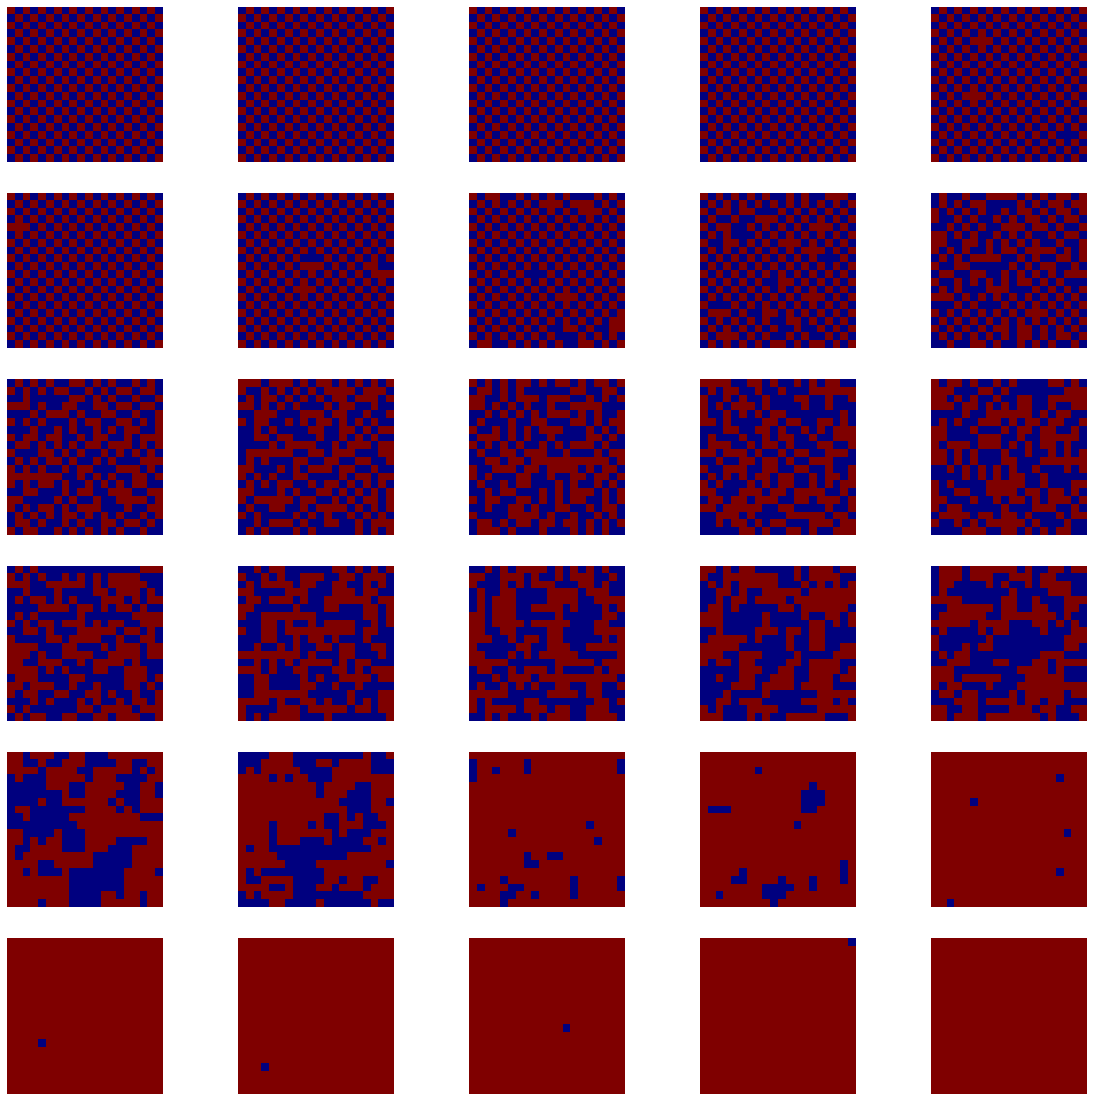

In [ ]:
nc = 30 
c_scale = int(x_train.shape[0]/nc)

rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

print('Snapshots of Ising model')
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))   
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(x_train[i*c_scale,:,:,0], cmap = 'jet', vmin = -1, vmax = 1)
    ax2.axis('Off')
    # print(x_train[i*c_scale,:,:,0].sum())
    # ax2.set_title('Time ' + str(i + 1))
plt.show()

In [ ]:
c_scale

1066

# DC GAN

In [ ]:
#x_train_gan = (x_train+1)/2
#
#for i, im in enumerate(x_train_gan):
#  x_train_gan[i,:,:,0] = im[:,:,0] + np.random.normal(loc=0.0, scale=0.1, size=(20,20))

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model

def build_generator(inputs, image_size):

    image_resize = image_size // 4
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    x = Dense(image_resize * image_resize * layer_filters[0])(inputs)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)

    x = Activation('sigmoid')(x)
    generator = Model(inputs, x, name='generator')
    return generator


def build_discriminator(inputs):

    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs
    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model(inputs, x, name='discriminator')
    return discriminator


def train(models, x_train_gan, params):
  
    generator, discriminator, adversarial = models
    batch_size, latent_size, train_steps, model_name = params
    save_interval = 500

    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    train_size = x_train_gan.shape[0]

    for i in range(train_steps):
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train_gan[rand_indexes]
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        fake_images = generator.predict(noise)
        x = np.concatenate((real_images, fake_images))
        y = np.ones([2 * batch_size, 1])
        y[batch_size:, :] = 0.0
        loss, acc = discriminator.train_on_batch(x, y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        y = np.ones([batch_size, 1])
        loss, acc = adversarial.train_on_batch(noise, y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)

        if (i + 1) % save_interval == 0:
            plot_images(generator, noise_input=noise_input,
                        show=True, step=(i + 1),
                        model_name=model_name)
            
    generator.save(model_name + ".h5")


def plot_images(generator, noise_input, show=True, step=0, model_name="gan"):

    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict(noise_input)

    plt.figure(figsize=(10, 10))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))

    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')


def build_and_train_models(x_train_gan):

    x_train_gan = x_train_gan.astype('float32') 
    image_size = x_train_gan.shape[1]

    model_name = "DCGAN2_Ising"

    latent_size = 10
    batch_size = 64
    train_steps = 20000

    lr = 2e-4
    decay = 6e-7 # 6e-8

    input_shape = (image_size, image_size, 1)
    inputs = Input(shape=input_shape, name='discriminator_input')
    discriminator = build_discriminator(inputs)
    optimizer = RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    discriminator.summary()

    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, image_size)
    generator.summary()

    optimizer = RMSprop(lr=lr * 0.5, decay=decay * 0.5)
    discriminator.trainable = False
    adversarial = Model(inputs, discriminator(generator(inputs)), name=model_name)
    adversarial.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    adversarial.summary()

    models = (generator, discriminator, adversarial)
    params = (batch_size, latent_size, train_steps, model_name)
    train(models, x_train_gan, params)


def test_generator(generator):
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 10])
    plot_images(generator, noise_input=noise_input, show=True, model_name="test_outputs")


In [ ]:
build_and_train_models(x_train_gan)

- Try Wassersteit GAN
- Try VAE (and then cVAE)

# Wasserstein GAN

In [ ]:
'''GAN model builder and util functions
[1] Radford, Alec, Luke Metz, and Soumith Chintala.
"Unsupervised representation learning with deep convolutional
generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).
'''


from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model

import numpy as np
import math
import matplotlib.pyplot as plt
import os

def gan_generator(inputs,
              image_size,
              activation='sigmoid',
              labels=None,
              codes=None):
    """Build a Generator Model
    Stack of BN-ReLU-Conv2DTranpose to generate fake images.
    Output activation is sigmoid instead of tanh in [1].
    Sigmoid converges easily.
    Arguments:
        inputs (Layer): Input layer of the generator (the z-vector)
        image_size (int): Target size of one side 
            (assuming square image)
        activation (string): Name of output activation layer
        labels (tensor): Input labels
        codes (list): 2-dim disentangled codes for InfoGAN
    Returns:
        Model: Generator Model
    """
    image_resize = image_size // 4
    # network parameters
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    if labels is not None:
        if codes is None:
            # ACGAN labels
            # concatenate z noise vector and one-hot labels
            inputs = [inputs, labels]
        else:
            # infoGAN codes
            # concatenate z noise vector, 
            # one-hot labels and codes 1 & 2
            inputs = [inputs, labels] + codes
        x = concatenate(inputs, axis=1)
    elif codes is not None:
        # generator 0 of StackedGAN
        inputs = [inputs, codes]
        x = concatenate(inputs, axis=1)
    else:
        # default input is just 100-dim noise (z-code)
        x = inputs

    x = Dense(image_resize * image_resize * layer_filters[0])(x)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)

    if activation is not None:
        x = Activation(activation)(x)

    # generator output is the synthesized image x
    return Model(inputs, x, name='generator')


def gan_discriminator(inputs,
                  activation='sigmoid',
                  num_labels=None,
                  num_codes=None):
    """Build a Discriminator Model
    Stack of LeakyReLU-Conv2D to discriminate real from fake
    The network does not converge with BN so it is not used here
    unlike in [1]
    Arguments:
        inputs (Layer): Input layer of the discriminator (the image)
        activation (string): Name of output activation layer
        num_labels (int): Dimension of one-hot labels for ACGAN & InfoGAN
        num_codes (int): num_codes-dim Q network as output 
                    if StackedGAN or 2 Q networks if InfoGAN
                    
    Returns:
        Model: Discriminator Model
    """
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs
    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
    # default output is probability that the image is real
    outputs = Dense(1)(x)
    if activation is not None:
        print(activation)
        outputs = Activation(activation)(outputs)

    if num_labels:
        # ACGAN and InfoGAN have 2nd output
        # 2nd output is 10-dim one-hot vector of label
        layer = Dense(layer_filters[-2])(x)
        labels = Dense(num_labels)(layer)
        labels = Activation('softmax', name='label')(labels)
        if num_codes is None:
            outputs = [outputs, labels]
        else:
            # InfoGAN have 3rd and 4th outputs
            # 3rd output is 1-dim continous Q of 1st c given x
            code1 = Dense(1)(layer)
            code1 = Activation('sigmoid', name='code1')(code1)

            # 4th output is 1-dim continuous Q of 2nd c given x
            code2 = Dense(1)(layer)
            code2 = Activation('sigmoid', name='code2')(code2)

            outputs = [outputs, labels, code1, code2]
    elif num_codes is not None:
        # StackedGAN Q0 output
        # z0_recon is reconstruction of z0 normal distribution
        z0_recon =  Dense(num_codes)(x)
        z0_recon = Activation('tanh', name='z0')(z0_recon)
        outputs = [outputs, z0_recon]

    return Model(inputs, outputs, name='discriminator')


def train(models, x_train_gan, params):
    """Train the Discriminator and Adversarial Networks
    Alternately train Discriminator and Adversarial networks by batch.
    Discriminator is trained first with properly real and fake images.
    Adversarial is trained next with fake images pretending to be real
    Generate sample images per save_interval.
    # Arguments
        models (list): Generator, Discriminator, Adversarial models
        x_train (tensor): Train images
        params (list) : Networks parameters
    """
    # the GAN models
    generator, discriminator, adversarial = models
    # network parameters
    batch_size, latent_size, train_steps, model_name = params
    # the generator image is saved every 500 steps
    save_interval = 500
    # noise vector to see how the generator output 
    # evolves during training
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    # number of elements in train dataset
    train_size = x_train_gan.shape[0]
    for i in range(train_steps):
        # train the discriminator for 1 batch
        # 1 batch of real (label=1.0) and fake images (label=0.0)
        # randomly pick real images from dataset
        rand_indexes = np.random.randint(0,
                                         train_size, 
                                         size=batch_size)
        real_images = x_train_gan[rand_indexes]
        # generate fake images from noise using generator 
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0,
                                  1.0, 
                                  size=[batch_size, latent_size])
        # generate fake images
        fake_images = generator.predict(noise)
        # real + fake images = 1 batch of train data
        x = np.concatenate((real_images, fake_images))
        # label real and fake images
        # real images label is 1.0
        y = np.ones([2 * batch_size, 1])
        # fake images label is 0.0
        y[batch_size:, :] = 0.0
        # train discriminator network, log the loss and accuracy
        loss, acc = discriminator.train_on_batch(x, y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

        # train the adversarial network for 1 batch
        # 1 batch of fake images with label=1.0
        # since the discriminator weights are frozen 
        # in adversarial network only the generator is trained
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0,
                                  1.0, 
                                  size=[batch_size, latent_size])
        # label fake images as real or 1.0
        y = np.ones([batch_size, 1])
        # train the adversarial network 
        # note that unlike in discriminator training, 
        # we do not save the fake images in a variable
        # the fake images go to the discriminator input
        # of the adversarial for classification
        # log the loss and accuracy
        loss, acc = adversarial.train_on_batch(noise, y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        if (i + 1) % save_interval == 0:
            # plot generator images on a periodic basis
            plot_images(generator,
                        noise_input=noise_input,
                        show=False,
                        step=(i + 1),
                        model_name=model_name)
   
    # save the model after training the generator
    # the trained generator can be reloaded 
    # for future MNIST digit generation
    generator.save(model_name + ".h5")


def gan_plot_images(generator,
                noise_input,
                noise_label=None,
                noise_codes=None,
                show=True,
                step=0,
                model_name="gan"):
    """Generate fake images and plot them
    For visualization purposes, generate fake images
    then plot them in a square grid
    # Arguments
        generator (Model): The Generator Model for 
            fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name
    """
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    rows = int(math.sqrt(noise_input.shape[0]))
    if noise_label is not None:
        noise_input = [noise_input, noise_label]
        if noise_codes is not None:
            noise_input += noise_codes

    images = generator.predict(noise_input)
    plt.figure(figsize=(10, 10))
    num_images = images.shape[0]
    image_size = images.shape[1]
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')


def gan_test_generator(generator):
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
    plot_images(generator,
                noise_input=noise_input,
                show=True,
                model_name="test_outputs")

In [ ]:
'''Trains WGAN on MNIST using Keras
Trains a GAN using Wassertein loss. Similar to DCGAN except for
linear activation in output and use of n_critic training per
adversarial training. Discriminator weights are clipped as a
requirement of Lipschitz constraint.
[1] Radford, Alec, Luke Metz, and Soumith Chintala.
"Unsupervised representation learning with deep convolutional
generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).
[2] Arjovsky, Martin, Soumith Chintala, and Léon Bottou.
"Wasserstein GAN." arXiv preprint arXiv:1701.07875 (2017).
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

import numpy as np

import sys
sys.path.append("..")
# from lib import gan

def train(models, x_train_gan, params):
    """Train the Discriminator and Adversarial Networks
    Alternately train Discriminator and Adversarial
    networks by batch.
    Discriminator is trained first with properly labelled
    real and fake images for n_critic times.
    Discriminator weights are clipped as a requirement 
    of Lipschitz constraint.
    Generator is trained next (via Adversarial) with 
    fake images pretending to be real.
    Generate sample images per save_interval
    Arguments:
        models (list): Generator, Discriminator,
            Adversarial models
        x_train (tensor): Train images
        params (list) : Networks parameters
    """
    # the GAN models
    generator, discriminator, adversarial = models
    # network parameters
    (batch_size, latent_size, n_critic, 
            clip_value, train_steps, model_name) = params
    # the generator image is saved every 500 steps
    save_interval = 500
    # noise vector to see how the 
    # generator output evolves during training
    noise_input = np.random.uniform(-1.0,
                                    1.0, 
                                    size=[16, latent_size])
    # number of elements in train dataset
    train_size = x_train_gan.shape[0]
    # labels for real data
    real_labels = np.ones((batch_size, 1))
    for i in range(train_steps):
        # train discriminator n_critic times
        loss = 0
        acc = 0
        for _ in range(n_critic):
            # train the discriminator for 1 batch
            # 1 batch of real (label=1.0) and 
            # fake images (label=-1.0)
            # randomly pick real images from dataset
            rand_indexes = np.random.randint(0,
                                             train_size, 
                                             size=batch_size)
            real_images = x_train_gan[rand_indexes]
            # generate fake images from noise using generator
            # generate noise using uniform distribution
            noise = np.random.uniform(-1.0,
                                      1.0,
                                      size=[batch_size, latent_size])
            fake_images = generator.predict(noise)

            # train the discriminator network
            # real data label=1, fake data label=-1
            # instead of 1 combined batch of real and fake images,
            # train with 1 batch of real data first, then 1 batch
            # of fake images.
            # this tweak prevents the gradient 
            # from vanishing due to opposite
            # signs of real and fake data labels (i.e. +1 and -1) and 
            # small magnitude of weights due to clipping.
            real_loss, real_acc = \
                discriminator.train_on_batch(real_images,
                                             real_labels)
            fake_loss, fake_acc = \
                discriminator.train_on_batch(fake_images,
                                             -real_labels)
            # accumulate average loss and accuracy
            loss += 0.5 * (real_loss + fake_loss)
            acc += 0.5 * (real_acc + fake_acc)

            # clip discriminator weights to satisfy Lipschitz constraint
            for layer in discriminator.layers:
                weights = layer.get_weights()
                weights = [np.clip(weight,
                                   -clip_value,
                                   clip_value) for weight in weights]
                layer.set_weights(weights)

        # average loss and accuracy per n_critic training iterations
        loss /= n_critic
        acc /= n_critic
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

        # train the adversarial network for 1 batch
        # 1 batch of fake images with label=1.0
        # since the discriminator weights are frozen in 
        # adversarial network only the generator is trained
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[batch_size, latent_size])
        # train the adversarial network
        # note that unlike in discriminator training,
        # we do not save the fake images in a variable
        # the fake images go to the discriminator 
        # input of the adversarial for classification
        # fake images are labelled as real
        # log the loss and accuracy
        loss, acc = adversarial.train_on_batch(noise, real_labels)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        if (i + 1) % save_interval == 0:
            # plot generator images on a periodic basis
            gan_plot_images(generator,
                            noise_input=noise_input,
                            show=True,
                            step=(i + 1),
                            model_name=model_name)

    # save the model after training the generator
    # the trained generator can be reloaded 
    # for future MNIST digit generation
    generator.save(model_name + ".h5")


def wasserstein_loss(y_label, y_pred):
    return -K.mean(y_label * y_pred)


def build_and_train_models(x_train_gan):
    """Load the dataset, build WGAN discriminator,
    generator, and adversarial models.
    Call the WGAN train routine.
    """
    
    x_train_gan = x_train_gan.astype('float32') 
    image_size = x_train_gan.shape[1]

    model_name = "wgan_Ising"
    # network parameters
    # the latent or z vector is 100-dim
    latent_size = 100
    # hyper parameters from WGAN paper [2]
    n_critic = 5
    clip_value = 0.01
    batch_size = 64
    lr = 1e-5 #5e-5
    train_steps = 50000
    input_shape = (image_size, image_size, 1)

    # build discriminator model
    inputs = Input(shape=input_shape, name='discriminator_input')
    # WGAN uses linear activation in paper [2]
    discriminator = gan_discriminator(inputs, activation='linear')
    optimizer = RMSprop(lr=lr)
    # WGAN discriminator uses wassertein loss
    discriminator.compile(loss=wasserstein_loss,
                          optimizer=optimizer,
                          metrics=['accuracy'])
    discriminator.summary()

    # build generator model
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = gan_generator(inputs, image_size)
    generator.summary()

    # build adversarial model = generator + discriminator
    # freeze the weights of discriminator during adversarial training
    discriminator.trainable = False
    adversarial = Model(inputs,
                        discriminator(generator(inputs)),
                        name=model_name)
    adversarial.compile(loss=wasserstein_loss,
                        optimizer=optimizer,
                        metrics=['accuracy'])
    adversarial.summary()

    # train discriminator and adversarial networks
    models = (generator, discriminator, adversarial)
    params = (batch_size,
              latent_size,
              n_critic,
              clip_value,
              train_steps,
              model_name)
    train(models, x_train_gan, params)

In [ ]:
build_and_train_models(x_train)

In [ ]:
#generator = load_model(args.generator)
#gan_test_generator(generator)

- Try different T in set - works for -0.4
- Set up VAE

# VAE (AtomAI)

In [ ]:
#!pip install atomai
!pip install git+https://github.com/ziatdinovmax/atomai@maxdev --upgrade

  Cloning https://github.com/ziatdinovmax/atomai (to revision maxdev) to /tmp/pip-req-build-f3kueacy
  Running command git clone -q https://github.com/ziatdinovmax/atomai /tmp/pip-req-build-f3kueacy
  Running command git checkout -b maxdev --track origin/maxdev
  Switched to a new branch 'maxdev'
  Branch 'maxdev' set up to track remote branch 'maxdev' from 'origin'.
     |████████████████████████████████| 194kB 14.0MB/s 
     |████████████████████████████████| 870kB 24.1MB/s 
  Created wheel for atomai: filename=atomai-0.6.2-cp36-none-any.whl size=120266 sha256=4714e1517663ad54dde501d305114323eb58922340d23062f21861d164df9bae
  Stored in directory: /tmp/pip-ephem-wheel-cache-9pol1j8m/wheels/bb/c7/8c/0efd34c28b875a0e451edabea2abdcbf8227c4966f6e17bd9d
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174964 sha256=1113b66906d0c007352dbe6f799b6931c78a8c4a6c9a80b2d7ae3ff6f847dec6
  Stored in directory: /root/.cache/pip/wheels/fb/28/5d/95e69a718b35dd00169889b

In [ ]:
from PIL import Image
import atomai as aoi

In [ ]:
print(x_train.shape, x_train.min(), x_train_gan.min())
x_train2 = np.squeeze(x_train)

(32000, 20, 20, 1) -1.0 -0.4636250146802177


In [ ]:
# x_train2 = np.squeeze(2*x_train_gan - 1)

In [ ]:
import torch
from atomai.losses_metrics import kld_normal

class VAE2(aoi.models.VAE):
    def __init__(self, in_dim, latent_dim=2, nb_classes=0, seed=0, **kwargs):
        args = [in_dim, latent_dim, nb_classes, seed]
        super(VAE2, self).__init__(*args, **kwargs)
        self.sigmoid_out = True # to ensure correct decoding after training
    
    def elbo_fn(self, x, x_reconstr, *q_param):
        """
        Calculates ELBO
        """
        # flatten reconstructed and target images
        x = x.reshape(-1, 20 * 20)
        x_reconstr = x_reconstr.reshape(-1, 20 * 20)
        # Sigmoid "activation"
        beta = 0.10
        x_reconstr = 1 / (1 + torch.exp(-beta * x_reconstr))
        # Binary cross-entropy
        likelihood = (torch.sum(x * torch.log(x_reconstr + 1e-8) +
                      (1 - x) * torch.log(1 - x_reconstr + 1e-8), dim=-1))
        # KL divergence
        kl_z = kld_normal(q_param)
        return likelihood.mean() - kl_z.mean()


'''
r = torch.sum(x_reconstr * (1-x_reconstr).sum(), -1)
return likelihood.mean() - kl_z.mean() - r.mean()
'''

'\nr = torch.sum(x_reconstr * (1-x_reconstr).sum(), -1)\nreturn likelihood.mean() - kl_z.mean() - r.mean()\n'

In [ ]:
input_dim = (20, 20)

# Intitialize model
vae = VAE2(input_dim) 
# Train
vae.fit(x_train2, training_cycles=400, batch_size=100)

Epoch: 1/400, Training loss: 246.7318
Epoch: 2/400, Training loss: 169.8742
Epoch: 3/400, Training loss: 130.8266
Epoch: 4/400, Training loss: 105.8920
Epoch: 5/400, Training loss: 88.1601
Epoch: 6/400, Training loss: 74.7926
Epoch: 7/400, Training loss: 63.9662
Epoch: 8/400, Training loss: 53.4032
Epoch: 9/400, Training loss: 37.1802
Epoch: 10/400, Training loss: 17.4034
Epoch: 11/400, Training loss: -2.2890
Epoch: 12/400, Training loss: -22.8111
Epoch: 13/400, Training loss: -43.9450
Epoch: 14/400, Training loss: -66.6455
Epoch: 15/400, Training loss: -90.1123
Epoch: 16/400, Training loss: -113.1746
Epoch: 17/400, Training loss: -136.4398
Epoch: 18/400, Training loss: -159.1229
Epoch: 19/400, Training loss: -182.0903
Epoch: 20/400, Training loss: -205.1400
Epoch: 21/400, Training loss: -227.9261
Epoch: 22/400, Training loss: -250.3588
Epoch: 23/400, Training loss: -272.6327
Epoch: 24/400, Training loss: -294.6869
Epoch: 25/400, Training loss: -316.6558
Epoch: 26/400, Training loss: -

KeyboardInterrupt: ignored

In [ ]:
input_dim = (20, 20)

# Intitialize model
vae = aoi.models.VAE(input_dim, latent_dim = 2, loss = 'ce') #loss=“ce”
# Train
vae.fit(x_train2, training_cycles=200, batch_size=100)

In [ ]:
vae.manifold2d(d=20, origin='upper')

In [ ]:
l_mean, l_std = vae.encode(x_train2[:,:,:])

plt.figure(figsize = (6,6))
plt.scatter(l_mean[:,0], l_mean[:,1], c = y_train, cmap = "RdBu_r")
plt.show()

In [ ]:
# Add GMM and draw samples from GMM

#Here we can color-code the experimental image/frame based on the latent variable values

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from matplotlib.colors import LogNorm
from sklearn import mixture

nc = 12
z = l_mean

gmm = GaussianMixture(n_components=nc, covariance_type='full', random_state=42) #diag
gmm_zt = gmm.fit_predict(z)

# display predicted scores by the model as a contour plot
x = np.linspace(-5., 5.)
y = np.linspace(-5., 5.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

Z = -gmm.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 30))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(z[:, 0], z[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

In [ ]:
new_sample = gmm.sample(3000)[0].T
plt.scatter(new_sample[0], new_sample[1])

In [ ]:
import torch
a = torch.randn(1, 2, dtype=torch.float)
print(a)
plt.imshow(vae.decode(a)[0,:,:])

In [ ]:
list_val = []

for im in range(40):
  for jm in range(40):
    i, j = im/20.0-1, jm/20.0-1
    a = torch.tensor([i,j], dtype=torch.float)
    b = vae.decode(a)[0,:,:]
    c = b*(1-b)
    #plt.imshow(b)
    #plt.show()
    list_val.append(c.sum())

In [ ]:
d = np.array(list_val).reshape(40,40)
plt.imshow(d.T)
plt.colorbar()

# Ising model reconstruciton (Mani)

Ising parameter reconstruction by Mani



https://colab.research.google.com/drive/1_RmvTvNNMS3LsQu5YXixHUmFRTn3CWtE#scrollTo=jhFQmtt4I34r

In [ ]:
!gdown --id 1y-jWDha8jmqdk4lDV_et54Jk2wJxKSIP

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

J1_values = np.linspace(-3.0,3.0,80)
J2_values = np.linspace(-3.0,3.0,75)

sim_results = pickle.load(open('/content/Ising_configs_J1J2.p', 'rb'))
P_sim = np.array(list(sim_results['P']))

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Feb  6 14:47:35 2021

@author: 4sv
"""
import numpy as np
def arrangement(config):
    N = config.shape[0]
    n_occ = np.zeros(6)
    total = N*N
    for i in range(N):
        for j in range(N):
            cen = config[i,j]
            a = config[(i+1)%N,j]
            b = config[i,(j+1)%N]
            c = config[(i-1)%N,j]
            d = config[i,(j-1)%N]
            nbsum = a+b+c+d
            if (cen*nbsum) == 4:
                n_occ[0] = n_occ[0]+1
            elif (cen*nbsum) == 2:
                n_occ[1] = n_occ[1]+1
            elif (cen*nbsum) == -2:
                n_occ[4] = n_occ[4]+1
            elif (cen*nbsum) == -4:
                n_occ[5] = n_occ[5]+1
            elif nbsum == 0:
                if a == c:
                    n_occ[3] = n_occ[3]+1
                else:
                    n_occ[2] = n_occ[2]+1

    P = (n_occ*1.0)/total
    return P

In [ ]:
list_val_J1 = []
list_val_J2 = []

for im in range(40):
  for jm in range(40):
    i, j = im/10.0-2, jm/10.0-2
    a = torch.tensor([i,j], dtype=torch.float)
    b = vae.decode(a)[0,:,:]

    bl = list(map(lambda x: -1 if x<0 else 1, b.ravel())) 
    #plt.imshow(np.array(bl).reshape(20,20))
    #plt.show()

    P_im = arrangement(np.array(bl).reshape(20,20))

    s = np.zeros(len(J1_values)*len(J2_values))
    for i in range(len(s)):
      s[i] = np.arccos(np.dot(np.sqrt(P_im),np.sqrt(P_sim[i,:])))

    min_index = np.unravel_index(np.argmin(s, axis=None), (len(J1_values),len(J2_values)))
    J1 = J1_values[min_index[0]]
    J2 = J2_values[min_index[1]]

    list_val_J1.append(J1)
    list_val_J2.append(J2)

In [ ]:
d1, d2 = np.array(list_val_J1).reshape(40,40), np.array(list_val_J2).reshape(40,40)

plt.imshow(d1.T, vmin= -1, vmax = 1)
plt.colorbar()
plt.show()

plt.imshow(d2.T, vmin= -1, vmax = 1)
plt.colorbar()
plt.show()

# Ising reconstruction - J only

In [ ]:
!gdown --id 1gxLViMoanCdQoA8bg9MbX1C8w2yfyCH-
J_results = pickle.load(open('Ising_configs_J_only.p', 'rb'))
J_values = np.linspace(-3.0,3.0,100)

import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Check L values intervals

list_val_J = []
list_val_s = []

P_sim = np.array(list(J_results['P']))

for im in range(40):
  for jm in range(40):
    i, j = im/10.0-2, jm/10.0-2
    a = torch.tensor([i,j], dtype=torch.float)
    b = vae.decode(a)[0,:,:]

    bl = list(map(lambda x: -1 if x<0 else 1, b.ravel())) 
    #plt.imshow(np.array(bl).reshape(20,20))
    #plt.show()

    P_im = arrangement(np.array(bl).reshape(20,20))

    s = np.zeros(len(J_values))
    for i in range(len(s)):
      s[i] = np.arccos(np.dot(np.sqrt(P_im),np.sqrt(P_sim[i,:])))

    min_index = np.argmin(s)
    J = J_values[min_index]
    # print(J, np.amin(s))

    list_val_J.append(J)
    list_val_s.append(min_index)

In [ ]:
d1, d2 = np.array(list_val_J).reshape(40,40), np.array(list_val_s).reshape(40,40)

plt.imshow(d1.T, vmin = -2, vmax = 2)
plt.colorbar()
plt.show()

plt.imshow(d2.T)
plt.colorbar()
plt.show()

In [ ]:
print(x_train.shape, y_train.shape, x_train.min())
print(np.array(list_val_J).mean(), np.array(list_val_J).std())

In [ ]:
# Compare real J, reconstructed J, J after encoding-decoding

list_val_J_real = []
list_val_J_image = []
list_val_J_ed = []

for ic in range(x_train.shape[0]):

  if ic%100 == 0:
    print('Step ', ic)

  # Real value
  list_val_J_real.append(y_train[ic])

  #Value from image
  P_im = arrangement(x_train[ic,:,:,0])

  s = np.zeros(len(J_values))
  for i in range(len(s)):
    s[i] = np.arccos(np.dot(np.sqrt(P_im),np.sqrt(P_sim[i,:])))

  min_index = np.argmin(s)
  J = J_values[min_index]
  list_val_J_image.append(J)

  #Value after encoding-decoding

  a_mean, a_sd = vae.encode(x_train[ic,:,:,0])
  b = vae.decode(a_mean)[0,:,:]

  #if ic%100 == 0:
  #  plt.imshow(b)
  #  plt.show()

  bl = list(map(lambda x: -1 if x<0 else 1, b.ravel())) 
  P_im = arrangement(np.array(bl).reshape(20,20))

  s = np.zeros(len(J_values))
  for i in range(len(s)):
    s[i] = np.arccos(np.dot(np.sqrt(P_im),np.sqrt(P_sim[i,:])))

  min_index = np.argmin(s)
  J = J_values[min_index]    
  list_val_J_ed.append(J)

In [ ]:
plt.scatter(np.arange(len(y_train)), list_val_J_real)
plt.scatter(np.arange(len(y_train)), list_val_J_image)
plt.scatter(np.arange(len(y_train)), list_val_J_ed)

In [ ]:
plt.scatter(list_val_J_real, list_val_J_image)
plt.scatter(list_val_J_real, list_val_J_ed)

In [ ]:
import seaborn as sns
import pandas as pd

from scipy.stats import gaussian_kde
import matplotlib.ticker as mtick

data = np.vstack((list_val_J_real, list_val_J_image, list_val_J_ed)).T
data = pd.DataFrame(data, columns=['J_real', 'J_image', 'J_ed'])

data.tail()

In [ ]:
arr_i = []

for i, val in enumerate(list(data['J_real']. unique())):
  col_temp = data[data['J_real']==val]
  arr_i.append((val, col_temp['J_image'].mean(), col_temp['J_image'].std(),
                col_temp['J_ed'].mean(), col_temp['J_ed'].std()))
  
arr_i = np.array(arr_i)

In [ ]:
plt.errorbar(arr_i[:,0],arr_i[:,1],arr_i[:,2])
plt.errorbar(arr_i[:,0],arr_i[:,3],arr_i[:,4])
plt.plot((-1, 1),(-1,1))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 300

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

# Offset VAE (Pyro)

In [ ]:
!pip install pyro-ppl

Imports:

In [ ]:
from typing import Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim
import torch
import torch.nn as nn
import torch.tensor as tt
from scipy.stats import norm
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [ ]:
#@title Load encoder and decoder NN architectures
def make_fc_layers(in_dim: int,
                   hidden_dim: int = 128,
                   num_layers: int = 2,
                   activation: str = "tanh"
                   ) -> Type[nn.Module]:
    activations = {"tanh": nn.Tanh, "lrelu": nn.LeakyReLU, "softplus": nn.Softplus}
    fc_layers = []
    for i in range(num_layers):
        hidden_dim_ = in_dim if i == 0 else hidden_dim
        fc_layers.extend(
            [nn.Linear(hidden_dim_, hidden_dim),
            activations[activation]()])
    fc_layers = nn.Sequential(*fc_layers)
    return fc_layers


class fcEncoderNet(nn.Module):

    def __init__(self,
                 in_dim: Tuple[int],
                 latent_dim: int = 2,
                 hidden_dim:int = 128,
                 num_layers: int = 2,
                 activation: str = 'tanh',
                 softplus_out: bool = False
                 ) -> None:
        super(fcEncoderNet, self).__init__()
        if len(in_dim) not in [1, 2, 3]:
            raise ValueError("in_dim must be (h, w), (h, w, c), or (h*w*c,)")
        self.in_dim = torch.prod(tt(in_dim)).item()

        self.fc_layers = make_fc_layers(
            self.in_dim, hidden_dim, num_layers, activation)
        self.fc11 = nn.Linear(hidden_dim, latent_dim)
        self.fc12 = nn.Linear(hidden_dim, latent_dim)
        self.activation_out = nn.Softplus() if softplus_out else lambda x: x

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor]:
        x = x.view(-1, self.in_dim)
        x = self.fc_layers(x)
        mu = self.fc11(x)
        log_sigma = self.activation_out(self.fc12(x))
        return mu, log_sigma


class rDecoderNet(nn.Module):

    def __init__(self,
                 out_dim: Tuple[int],
                 latent_dim: int,
                 hidden_dim:int = 128,
                 num_layers: int = 2,
                 activation: str = 'tanh',
                 sigmoid_out: str = 'sigmoid'
                 ) -> None:
        super(rDecoderNet, self).__init__()
        if len(out_dim) not in [1, 2, 3]:
            raise ValueError("in_dim must be (h, w), (h, w, c), or (h*w*c,)")
        self.reshape = out_dim
        out_dim = torch.prod(tt(out_dim)).item()

        self.coord_latent = coord_latent(latent_dim, hidden_dim)
        self.fc_layers = make_fc_layers(
            hidden_dim, hidden_dim, num_layers, activation)
        self.out = nn.Linear(hidden_dim, 1) # need to generalize to multi-channel (c > 1)
        self.activation_out = nn.Sigmoid() if sigmoid_out else lambda x: x

    def forward(self, x_coord: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        x = self.coord_latent(x_coord, z)
        x = self.fc_layers(x)
        x = self.activation_out(self.out(x))
        return x.view(-1, *self.reshape)


class coord_latent(nn.Module):
    
    def __init__(self,
                 latent_dim: int,
                 out_dim: int,
                 activation_out: bool = True) -> None:

        super(coord_latent, self).__init__()
        self.fc_coord = nn.Linear(2, out_dim)
        self.fc_latent = nn.Linear(latent_dim, out_dim, bias=False)
        self.activation = nn.Tanh() if activation_out else None

    def forward(self,
                x_coord: torch.Tensor,
                z: torch.Tensor) -> torch.Tensor:

        batch_dim, n = x_coord.size()[:2]
        x_coord = x_coord.reshape(batch_dim * n, -1)
        h_x = self.fc_coord(x_coord)
        h_x = h_x.reshape(batch_dim, n, -1)
        h_z = self.fc_latent(z)
        h = h_x.add(h_z.unsqueeze(1))
        h = h.reshape(batch_dim * n, -1)
        if self.activation is not None:
            h = self.activation(h)
        return h

In [ ]:
#@title Load functions for working with coordinate grid
def grid2xy(X1: torch.Tensor, X2: torch.Tensor) -> torch.Tensor:
    X = torch.cat((X1[None], X2[None]), 0)
    d0, d1 = X.shape[0], X.shape[1] * X.shape[2]
    X = X.reshape(d0, d1).T
    return X


def imcoordgrid(im_dim: Tuple) -> torch.Tensor:
    xx = torch.linspace(-1, 1, im_dim[0])
    yy = torch.linspace(1, -1, im_dim[1])
    x0, x1 = torch.meshgrid(xx, yy)
    return grid2xy(x0, x1)


def transform_coordinates(coord: torch.Tensor,
                          phi: Union[torch.Tensor, float] = 0,
                          coord_dx: Union[torch.Tensor, float] = 0,
                          ) -> torch.Tensor:

    if torch.sum(phi) == 0:
        phi = coord.new_zeros(coord.shape[0])
    rotmat_r1 = torch.stack([torch.cos(phi), torch.sin(phi)], 1)
    rotmat_r2 = torch.stack([-torch.sin(phi), torch.cos(phi)], 1)
    rotmat = torch.stack([rotmat_r1, rotmat_r2], axis=1)
    coord = torch.bmm(coord, rotmat)

    return coord + coord_dx

In [ ]:
batch_size = 32
# Select dataset
dataset = np.squeeze(x_train_gan)

train_set = torch.utils.data.dataset.TensorDataset(
    torch.from_numpy(dataset[:, None]).float())
train_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=batch_size, shuffle=True)

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, (img,) in zip(axes.flat, train_loader):
    ax.imshow(img[0, 0], cmap='gnuplot', interpolation='nearest')

Define rVAE as a probabilistic model:

In [ ]:
class rVAE(nn.Module):
    """
    rVAE as probabilistic Pyro model
    """
    def __init__(self,
                 in_dim: Tuple[int],
                 latent_dim: int = 2,
                 coord: int = 3,
                 hidden_dim_e: int = 128,
                 hidden_dim_d: int = 128,
                 num_layers_e: int = 2,
                 num_layers_d: int = 2,
                 activation: str = "tanh",
                 softplus_sd: bool = True,
                 sigmoid_out: bool = True,
                 **kwargs
                 ) -> None:
        """
        Initializes rVAE parameters including setting up encoder and decoder
        neural networks
        """
        super(rVAE, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.encoder = fcEncoderNet(
            in_dim, latent_dim+coord, hidden_dim_e,
            num_layers_e, activation, softplus_sd)
        self.decoder = rDecoderNet(
            in_dim, latent_dim, hidden_dim_d,
            num_layers_d, activation, sigmoid_out)
        self.z_dim = latent_dim + coord
        self.coord = coord
        self.grid = imcoordgrid(in_dim)
        self.dx_prior = kwargs.get("dx_prior", 0.1)
        self.to(self.device)

    def model(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the model p(x|z)p(z)
        """
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        reshape_ = torch.prod(tt(x.shape[1:])).item()
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # split latent variable into parts for rotation and/or translation and image content
            phi, dx = tt(0), tt(0)
            # rotation + translation
            if self.coord == 3: 
                phi = z[:, 0] # encoded angle
                dx = z[:, 1:3]  # translation
                z = z[:, 3:]  # image content
            # translation only
            elif self.coord == 2:
                dx = z[:, :2]
                z = z[:, 2:]
            # rotation only
            elif self.coord == 1: 
                phi = z[:, 0]
                z = z[:, 1:]
            if torch.sum(dx) != 0:
                dx = (dx * self.dx_prior).unsqueeze(1)
            # transform coordinate grid
            grid = self.grid.expand(x.shape[0], *self.grid.shape).to(self.device)
            x_coord_prime = transform_coordinates(grid, phi, dx)
            # decode the latent code z + the stransformed grid
            loc_img = self.decoder(x_coord_prime, z)
            # score against actual images (basically "binary cross-entropy loss")
            pyro.sample(
                "obs", dist.Bernoulli(loc_img.view(-1, reshape_)).to_event(1),
                obs=x.view(-1, reshape_))
    
    def guide(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the guide (i.e. variational distribution) q(z|x)
        """
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

Define stochastic variational inference (SVI) trainer class for model training and evaluation:

In [ ]:
class SVItrainer:
    """
    Stochastic variational inference (SVI) trainer for variational models
    """

    def __init__(self,
                 model: Type[nn.Module],
                 optimizer: Type[optim.PyroOptim] = None,
                 loss: Type[infer.ELBO] = None,
                 seed: int = 1
                 ) -> None:
        """
        Initializes trainer parameters
        """
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.manual_seed_all(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
        pyro.clear_param_store()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        if optimizer is None:
            optimizer = optim.Adam({"lr": 1.0e-3})
        if loss is None:
            loss = infer.Trace_ELBO()
        self.svi = infer.SVI(model.model, model.guide, optimizer, loss=loss)
        self.loss_history = {"training_loss": [], "test_loss": []}
        self.current_epoch = 0

    def train(self, train_loader: Type[torch.utils.data.DataLoader]) -> float:
        """
        Train a single epoch
        """
        # initialize loss accumulator
        epoch_loss = 0.
        # do a training epoch over each mini-batch x returned
        # by the data loader
        for data in train_loader:
            if len(data) == 1:  # VAE mode
                x = data[0]
                loss = self.svi.step(x.to(self.device))
            else:  # VED or cVAE mode
                x, y = data
                loss = self.svi.step(x.to(self.device), y.to(self.device))
            # do ELBO gradient and accumulate loss
            epoch_loss += loss

        return epoch_loss / len(train_loader.dataset)

    def evaluate(self, test_loader: Type[torch.utils.data.DataLoader]) -> float:
        """
        Evaluate current models state on a single epoch
        """
        # initialize loss accumulator
        test_loss = 0.
        # compute the loss over the entire test set
        with torch.no_grad():
            for data in test_loader:
                if len(data) == 1:  # VAE mode
                    x = data[0]
                    loss = self.svi.step(x.to(self.device))
                else:  # VED or cVAE mode
                    x, y = data
                    loss = self.svi.step(x.to(self.device), y.to(self.device))
                test_loss += loss

        return test_loss / len(test_loader.dataset)

    def step(self,
             train_loader: Type[torch.utils.data.DataLoader],
             test_loader: Optional[Type[torch.utils.data.DataLoader]] = None
             ) -> None:
        """
        Single training and (optionally) evaluation step 
        """
        self.loss_history["training_loss"].append(self.train(train_loader))
        if test_loader is not None:
            self.loss_history["test_loss"].append(self.evaluate(test_loader))
        self.current_epoch += 1

    def print_statistics(self) -> None:
        """
        Print training and test (if any) losses for current epoch
        """
        e = self.current_epoch
        if len(self.loss_history["test_loss"]) > 0:
            template = 'Epoch: {} Training loss: {:.4f}, Test loss: {:.4f}'
            print(template.format(e, self.loss_history["training_loss"][-1],
                                  self.loss_history["test_loss"][-1]))
        else:
            template = 'Epoch: {} Training loss: {:.4f}'
            print(template.format(e, self.loss_history["training_loss"][-1]))


Train our model:

(note: for datasets with large rotations it is better to train for up to ~1000 epochs)

In [ ]:
in_dim = (20, 20)
# Initialize probabilistic model
# coord=1: rotations only
# coord=2: translations only
# coord=3: rotations+translations
vae = rVAE(in_dim, latent_dim=2, coord=2, dx_prior=0.05)
# Initialize SVI trainer
trainer = SVItrainer(vae)
# Train for n epochs:
for _ in range(250):
    trainer.step(train_loader)
    trainer.print_statistics()

In [ ]:
plt.plot(trainer.loss_history["training_loss"])
plt.yscale("log")

Plot a learned manifold:

In [ ]:
d = 9

device = 'cuda' if torch.cuda.is_available else 'cpu'

# Sweep over linearly spaced coordinates transformed through the
# inverse CDF of a gaussian since the prior of the latent
# space is gaussian
grid_x = norm.ppf(torch.linspace(0.05, 0.95, d))
grid_y = norm.ppf(torch.linspace(0.05, 0.95, d))
loc_img_all = []
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = torch.tensor([xi, yi]).float().to(device)
        x_coord = imcoordgrid((20, 20)).to(device)
        loc_img = vae.decoder(x_coord[None], z_sample[None]).detach().cpu()
        loc_img_all.append(loc_img)
loc_img_all = torch.cat(loc_img_all)

grid = make_grid(loc_img_all[:, None], nrow=d, padding=2, pad_value=1)
plt.figure(figsize=(8, 8))
plt.imshow(grid[0], cmap='gnuplot')

Now let's train with "wrong" (i.e., very small) prior for offset:

In [ ]:
in_dim = (20, 20)
# Initialize probabilistic model
vae = rVAE(in_dim, latent_dim=2, coord=2, dx_prior=0.1) # adjust dx prior
# Initialize SVI trainer
trainer = SVItrainer(vae)
# Train for n epochs:
for _ in range(250):
    trainer.step(train_loader)
    trainer.print_statistics()

In [ ]:
plt.plot(trainer.loss_history["training_loss"])
plt.yscale("log")

Plot a learned manifold:

In [ ]:
d = 9

device = 'cuda' if torch.cuda.is_available else 'cpu'

# Sweep over linearly spaced coordinates transformed through the
# inverse CDF of a gaussian since the prior of the latent
# space is gaussian
grid_x = norm.ppf(torch.linspace(0.05, 0.95, d))
grid_y = norm.ppf(torch.linspace(0.05, 0.95, d))
loc_img_all = []
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = torch.tensor([xi, yi]).float().to(device)
        x_coord = imcoordgrid((20, 20)).to(device)
        loc_img = vae.decoder(x_coord[None], z_sample[None]).detach().cpu()
        loc_img_all.append(loc_img)
loc_img_all = torch.cat(loc_img_all)

grid = make_grid(loc_img_all[:, None], nrow=d, padding=2, pad_value=1)
plt.figure(figsize=(8, 8))
plt.imshow(grid[0], cmap='gnuplot')